01 - Baseline Encoding Benchmark Code (Starting Code)

This Notebook is created for implementing the baseline categorical encoding benchmark for regression datasets. 

1. First step to setup the environment is to import the necessary tools.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder as SklearnOrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin



# category encoders import
import category_encoders as ce

# UCI ML Repository import
from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


Now we have to load and prepare the data using try block, so we could find out the error, if there is one.

In [2]:
def load_ames_data():
    # Loading and preparing ames dataset
    try:
        train_data = pd.read_csv("../data/raw/ames-housing-dataset/AmesHousing.csv", index_col=0)

        # preprocessing steps
        # filling the categorical features missing values
        cat_cols_before_exclusion = train_data.select_dtypes(include="object").columns.tolist()
        train_data[cat_cols_before_exclusion] = train_data[cat_cols_before_exclusion].fillna("missing")

        # filling the numerical features missing values
        num_cols_before_exclusion = train_data.select_dtypes(include="number").columns.to_list()
        train_data[num_cols_before_exclusion] = train_data[num_cols_before_exclusion].fillna(-1)  

        # excluding the useless columns from train data
        columns_to_exclude = ["Order", "PID", "SalePrice"]
        selected_columns = [col for col in train_data.columns if col not in columns_to_exclude]

        # Defining X and y (input and target value)
        X = train_data[selected_columns]
        y = train_data["SalePrice"]

        # column lists after exclusion
        cat_columns = X.select_dtypes(include="object").columns.tolist()
        num_columns = X.select_dtypes(include="number").columns.tolist()

        # return the train data
        return X, y, cat_columns, num_columns
        

    except FileNotFoundError:
        print("Dataset was not found!")
        return None

In [3]:
def load_student_data(subject = "math"):
    """
    Load and prepare Student Performance dataset from UCI ML Repository
    
    Parameters:
    -----------
    subject : str, default='math'
        Either 'math' or 'portuguese' to select the specific dataset
    
    Returns:
    --------
    X : pd.DataFrame
        Features
    y : pd.Series
        Target variable (G3 - final grade)
    cat_columns : list
        Categorical column names
    num_columns : list
        Numerical column names
    
    Notes:
    ------
    - G1 and G2 (intermediate grades) are removed to prevent data leakage
    - Target is G3 (final grade, range 0-20)
    - Data is fetched directly from UCI ML Repository
    """
    try:
        # Fetch dataset from UCI ML Repository
        print(f"Fetching Student Performance ({subject}) dataset from UCI...")
        student_performance = fetch_ucirepo(id=320)
        
        # Get features and targets
        X = student_performance.data.features
        y = student_performance.data.targets
        
        # The dataset has G1, G2, G3 in targets
        # We want to predict G3 (final grade) and remove G1, G2 to avoid data leakage
        if isinstance(y, pd.DataFrame):
            if 'G3' in y.columns:
                y = y['G3']
            else:
                # If G3 is not in targets, it might be in features
                if 'G3' in X.columns:
                    y = X['G3']
                    X = X.drop(columns=['G3'])
        
        # Remove G1 and G2 to prevent temporal data leakage
        columns_to_remove = ['G1', 'G2']
        X = X.drop(columns=[col for col in columns_to_remove if col in X.columns], errors='ignore')
        
        # Identify categorical and numerical columns
        cat_columns = X.select_dtypes(include='object').columns.tolist()
        num_columns = X.select_dtypes(include='number').columns.tolist()
        
        return X, y, cat_columns, num_columns
    except Exception as e:
        print(f"✗ Error loading Student Performance dataset: {e}")
        print("Make sure you have installed: pip install ucimlrepo\n")
        return None, None, None, None

        

In [4]:
DATASETS_TO_RUN = {
    'Ames_Housing': load_ames_data,
    'Student_Performance_Math': lambda: load_student_data(subject='math'),
}

In [5]:
class MutualInfoFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom transformer for feature selection using Mutual Information.
    Works inside scikit-learn pipelines and cross-validation. The purpose of it is to avoid data-leakage, and run feature selection in each CV-fold.
    """
    def __init__(self, cat_columns, num_columns, feature_keep_percent = 80, random_state = 42):
        self.cat_columns = cat_columns
        self.num_columns = num_columns
        self.feature_keep_percent = feature_keep_percent
        self.random_state = random_state
    
    def fit(self, X, y):
        """
        Fit the feature selector on training data. Also called seperately for each CV fold.
        """

        # if condition to check if X is in dataframe type
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Copying the X and encode the categorical columns
        X_encoded = X.copy()
        for col in self.cat_columns:
            if col in X_encoded.columns:
                # convert categorical columns to numerical
                X_encoded[col] = pd.factorize(X_encoded[col])[0]

        # Calculating the Number of features to keep
        n_features = int(len(X.columns) * (self.feature_keep_percent/100))

        # Selecting features using Mutual Information
        self.selector_ = SelectKBest(mutual_info_regression, k=n_features)
        self.selector_.fit(X_encoded, y)

        # Storing the features
        self.selected_indices_ = self.selector_.get_support()
        self.selected_features_ = X.columns[self.selected_indices_].tolist()

        # Updating the categorical and numerical columns
        self.selected_cat_cols_ = [col for col in self.selected_features_ if col in self.cat_columns ]
        self.selected_num_cols_ = [col for col in self.selected_features_ if col in self.num_columns]

        return self
    
    # Define the transform function
    def transform(self, X):
        """
        Transforming by solely using the chosen features
        """
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X[self.selected_features_]
    
    def get_feature_names_out(self, input_features=None):
        """
        Getting Features names out.,
        """
        return self.selected_features_
        


Now we have to define a baseline benchmark class, that we could reuse.

In [6]:
class EncodingBenchmark:
    """
    Starting baseline to test core encoder-algorithm interactions by going through 4 Senarios as described below:
    1. No column removal, no encoding (baseline with raw data)
    2. No column removal, with encoding
    3. Column removal, no encoding (feature selection only)
    4. Column removal, with encoding (optimized pipeline)
    
    Tests 3 encoders named OneHotEncoder, TargetEncoder, OrdinalEncoder with 2 representative algorithms named Ridge and RandomForest to validate the fundamental hypothesis that encoding choice affects performance. 
    """
    
    # defining the init
    def __init__(self, random_state = 42):
        self.random_state = random_state

        # encoders
        self.encoders = {
            "OneHotEncoder" : OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
            "TargetEncoder" : ce.TargetEncoder(smoothing=15, min_samples_leaf=20),
            "OrdinalEncoder" : SklearnOrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1),
            "CatBoostEncoder": ce.CatBoostEncoder(sigma=2, a=1),
            "LeaveOneOutEncoder": ce.LeaveOneOutEncoder()            
        }

        # machine learning algorithms
        self.algorithms = {
            "Ridge" : Ridge(random_state=self.random_state),
            "RandomForest" : RandomForestRegressor(n_estimators=100, random_state=self.random_state, max_depth=15, n_jobs=-1),
            "XGBoost" : xgb.XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 6, random_state=self.random_state),
            "CatBoost": CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, random_state=self.random_state, verbose=False)
        }



    """   manual feature selection should be deleted, since it caused data leakage and worse performance in scenario 4
      # selecting more relevant feautures
    def feature_selection(self, X, y, cat_columns, num_columns, feature_keep_percent =70):
         
        In this method, we keep the 70 percent of the top features based on the mutual information with target value using mutual information gain from scikit (sklearn)

        # Converting categorical columns to numerical temporarily for computing the mutual information (MI)
        X_encoded = X.copy()
        for col in cat_columns:
            X_encoded[col] = pd.factorize(X_encoded[col])[0]
              

        # Calculating the mutual information score
        mi_scores = mutual_info_regression(X_encoded, y, random_state=self.random_state)
         
        # Calculating Number of features to keep, using the feature_keep_percent
        number_features_keep = int(len(X.columns) * (feature_keep_percent / 100)) 

        # Selecting top 70 percent features
        feature_selector = SelectKBest(mutual_info_regression, k=number_features_keep)
        feature_selector.fit(X_encoded, y)

        # Selecting features names
        selected_features = X.columns[feature_selector.get_support()].tolist()
        selected_cat_cols = [col for col in selected_features if col in cat_columns]
        selected_num_cols = [col for col in selected_features if col in num_columns]

        # Defining reduce train data
        X_reduced = X[selected_features]

        print(f"Mutual Information selection: {len(X.columns)} -> {len(X_reduced.columns)} features")
        print(f"  Kept top {feature_keep_percent}% most informative features")
    
        return X_reduced, selected_cat_cols, selected_num_cols"""
    

 


    # creating pipeline
    def create_pipeline(self, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True, apply_feature_selection=False, feature_keep_percent=70):
            """Create preprocessing and algorithming pipeline with optional encoding."""
            
            algorithm = self.algorithms[algorithm_name]

            #pipeline steps
            pipeline_steps=[]

            # Feature selection part (if enabled)
            if apply_feature_selection:
                 feature_selector = MutualInfoFeatureSelector(
                      cat_columns=cat_columns,
                      num_columns=num_columns,
                      feature_keep_percent=feature_keep_percent,
                      random_state=self.random_state
                 )
                 pipeline_steps.append(("feature_selection", feature_selector))

            # Preprocessing (Encoding and scaling using StandardScalar)
            if apply_encoding:
                 encoder = self.encoders[encoder_name]
            else:
                 # Minimal encoder for the scenarios without encoding
                 encoder = SklearnOrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1)
    
            preprocessor = ColumnTransformer([
            ("categorical", encoder, make_column_selector(dtype_include=object)),
            ("numerical", StandardScaler(), make_column_selector(dtype_include=np.number))
            ], remainder='drop')
    
            pipeline_steps.append(("preprocessor", preprocessor))
            pipeline_steps.append(("algorithm", algorithm))
    
            # Create pipeline
            pipeline = Pipeline(pipeline_steps)
    
            return pipeline
    
    """        if apply_encoding:
                 # In this case, it is scenario 2 or 4, which encoding is enabled in them
                 encoder = self.encoders[encoder_name]
                 #preprocessor
                 preprocessor = ColumnTransformer([
                 ("categorical", encoder, cat_columns),
                 ("numerical", StandardScaler(), num_columns)
            ])
            # Scenario 1 and 3, without any encoding     
            else:
                 # since sklearn does not understand categorical columns (texts), we have to choose a minimal encoder (ordinal encoder) so that we could run the sklearn without getting an error.
                 minimal_encoder = SklearnOrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
                 preprocessor = ColumnTransformer([
                 ("categorical", minimal_encoder, cat_columns),
                 ("numerical", StandardScaler(), num_columns)
                ])

            #pipeline implementation
            pipeline = Pipeline([
                ("preprocessor", preprocessor),
                ("algorithm", algorithm)
            ])
            return pipeline"""
        
    def evaluate_combination(self, X, y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True,apply_feature_selection=False, scenario = ""):
            """Evaluate one single combination of encoder and algorithm in a specific scenario."""

            try:
                # create an object of the class Pipeline
                new_pipeline = self.create_pipeline(encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding, apply_feature_selection)

                # define 5-fold cross validation CV
                cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=self.random_state)

                # Evaluation metrics
                rmse = -cross_val_score(new_pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
                rmse = np.sqrt(rmse)

                if apply_feature_selection:
                     n_features = int(X.shape[1] * 0.7)
                
                else:
                     n_features = X.shape[1]

                # results
                result = {
                'scenario': scenario,
                'encoder': encoder_name,
                'algorithm': algorithm_name,
                'rmse_mean': rmse.mean(),
                'rmse_std': rmse.std(),
                'number_features' : n_features
                }
            
                return result

            except Exception as e:
                print(f"There is an error with the combination of algorithm {algorithm_name} and the encoder {encoder_name} in {scenario}")
                return None
            
    def run_scenarios(self,X, y, cat_columns, num_columns):
         """Running four different scenarios, as described above."""
         results =[]

         # Scenario 1: no feature selection and no encoding
         print( "Running Scenario 1: No feature selection and no encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f" Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=False, apply_feature_selection=False, scenario="S1_No_Selection_No_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")

        # Scenario 2: no feature selection but with encoding
         print("Running Scenario 2: no feature selection, with encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f" Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True,apply_feature_selection=False, scenario="S2_No_Selection_With_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")

        # Scenario 3: With feature selection but no encoding
         print("Running Scenario 3: With feature selection, no encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f" Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=False, apply_feature_selection=True, scenario="S3_With_Selection_No_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")
        # Scenario 4: With feature selection and encoding
         print("Running Scenario 4: With feature selection and encoding")
         for encoder_name in self.encoders.keys():
              for algorithm_name in self.algorithms.keys():
                   print(f" Testing: {algorithm_name} + {encoder_name}")
                   result = self.evaluate_combination(X,y, encoder_name, algorithm_name, cat_columns, num_columns, apply_encoding=True, apply_feature_selection=True, scenario="S4_With_Selection_With_Encoding")
                   if result:
                        results.append(result)
                        print(f"RMSE: {result['rmse_mean']:,.0f}")
         return pd.DataFrame(results)

        
    # run the baseline test
    ## def run_baseline_test(self, X, y, cat_columns, num_columns):        
        
           ## results = []
        
          #  for encoder_name in self.encoders.keys():
               # for algorithm_name in self.algorithms.keys():
                   # print(f"Testing: {encoder_name} + {algorithm_name}")
                
                    #result = self.evaluate_combination(
                      #  X, y, encoder_name, algorithm_name, cat_columns, num_columns
                 #   )
                
                   # if result:
                     #   results.append(result)
                    #    print(f"  RMSE: {result['rmse_mean']:,.0f} (±{result['rmse_std']:,.0f})")

        
           ## return pd.DataFrame(results)
             ##
  
    # analyze the results (RMSE)
    def analyze_results(self, results_df):
        """analyze  results to validate core hypothesis across all four scenarios."""
        
        # Overall best by scenario
        print("\nBest Performance by Scenario:")
        for scenario in results_df['scenario'].unique():
            scenario_data = results_df[results_df['scenario'] == scenario]
            best = scenario_data.loc[scenario_data['rmse_mean'].idxmin()]
            print(f"{scenario}: {best['encoder']} + {best['algorithm']} = {best['rmse_mean']:,.0f}")
        
        # Compare scenarios
        print("\nScenario Comparison (Average RMSE across all combinations):")
        scenario_avg = results_df.groupby('scenario')['rmse_mean'].mean().sort_values()
        for scenario, avg_rmse in scenario_avg.items():
            print(f"{scenario}: {avg_rmse:,.0f}")
        
        # Impact of feature selection
        with_selection = results_df[results_df['scenario'].str.contains('With_Selection')]['rmse_mean'].mean()
        without_selection = results_df[results_df['scenario'].str.contains('No_Selection')]['rmse_mean'].mean()
        print(f"\nFeature Selection Impact:")
        print(f"  With Selection: {with_selection:,.0f}")
        print(f"  Without Selection: {without_selection:,.0f}")
        print(f"  Difference: {without_selection - with_selection:,.0f}")
        
        # Impact of encoding
        with_encoding = results_df[results_df['scenario'].str.contains('With_Encoding')]['rmse_mean'].mean()
        without_encoding = results_df[results_df['scenario'].str.contains('No_Encoding')]['rmse_mean'].mean()
        print(f"\nEncoding Impact:")
        print(f"  With Encoding: {with_encoding:,.0f}")
        print(f"  Without Encoding: {without_encoding:,.0f}")
        print(f"  Difference: {without_encoding - with_encoding:,.0f}")
        
        return results_df   
    
    # visualize the results for more comprehensive analysis of the RMSE 
    def visualize_results(self, results_df, dataset_name='dataset'):
        """
        Create visualizations comparing the 4 scenarios.
    
        Parameters:
        -----------
        results_df : pd.DataFrame
        Results from run_scenarios
        dataset_name : str, default='dataset'
        Name of the dataset for the plot title and filename
        """
    
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f"4-Scenario Benchmark: {dataset_name}\nFeature Selection × Encoding Impact", 
                fontsize=18, fontweight='bold')
    
    # 1. Scenario comparison
        scenario_avg = results_df.groupby('scenario')['rmse_mean'].mean().sort_values()
        axes[0,0].barh(scenario_avg.index, scenario_avg.values, color='steelblue')
        axes[0,0].set_xlabel('Average RMSE')
        axes[0,0].set_title('Average Performance by Scenario')
        axes[0,0].invert_yaxis()
    
    # 2. Encoder performance across scenarios
        encoder_scenario = results_df.groupby(['encoder', 'scenario'])['rmse_mean'].mean().unstack()
        encoder_scenario.plot(kind='bar', ax=axes[0,1], rot=45)
        axes[0,1].set_ylabel('RMSE')
        axes[0,1].set_title('Encoder Performance Across Scenarios')
        axes[0,1].legend(title='Scenario', fontsize=8, loc='best')
    
    # 3. Algorithm performance across scenarios
        algo_scenario = results_df.groupby(['algorithm', 'scenario'])['rmse_mean'].mean().unstack()
        algo_scenario.plot(kind='bar', ax=axes[1,0], rot=45)
        axes[1,0].set_ylabel('RMSE')
        axes[1,0].set_title('Algorithm Performance Across Scenarios')
        axes[1,0].legend(title='Scenario', fontsize=8, loc='best')
    
    # 4. Feature count vs RMSE
    # Defining distinct colors for telling the difference easier
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        for i, scenario in enumerate(results_df['scenario'].unique()):
            scenario_data = results_df[results_df['scenario'] == scenario]
            axes[1,1].scatter(scenario_data['number_features'], scenario_data['rmse_mean'], 
                        label=scenario, alpha=0.7, s=100, color=colors[i])
        axes[1,1].set_xlabel('Number of Features')
        axes[1,1].set_ylabel('RMSE')
        axes[1,1].set_title('Feature Count vs Performance')
        axes[1,1].legend(fontsize=8, loc='best', ncol=2, framealpha=0.9)
    
        plt.tight_layout()
    
    # Save with dataset-specific filename
        output_file = f'../results/{dataset_name}_four_scenario_comparison.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
    
        print(f"✓ Visualization saved to '{output_file}'")
        """""Create visualizations comparing the 4 scenarios
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle("4-Scenario Benchmark: Feature Selection × Encoding Impact", 
                    fontsize=18, fontweight='bold')
        
        # 1. Scenario comparison
        scenario_avg = results_df.groupby('scenario')['rmse_mean'].mean().sort_values()
        axes[0,0].barh(scenario_avg.index, scenario_avg.values, color='steelblue')
        axes[0,0].set_xlabel('Average RMSE ($)')
        axes[0,0].set_title('Average Performance by Scenario')
        axes[0,0].invert_yaxis()
        
        # 2. Encoder performance across scenarios
        encoder_scenario = results_df.groupby(['encoder', 'scenario'])['rmse_mean'].mean().unstack()
        encoder_scenario.plot(kind='bar', ax=axes[0,1], rot=45)
        axes[0,1].set_ylabel('RMSE ($)')
        axes[0,1].set_title('Encoder Performance Across Scenarios')
        axes[0,1].legend(title='Scenario', fontsize=8, loc='lower right')
        
        # 3. Algorithm performance across scenarios
        algo_scenario = results_df.groupby(['algorithm', 'scenario'])['rmse_mean'].mean().unstack()
        algo_scenario.plot(kind='bar', ax=axes[1,0], rot=45)
        axes[1,0].set_ylabel('RMSE ($)')
        axes[1,0].set_title('Algorithm Performance Across Scenarios')
        axes[1,0].legend(title='Scenario', fontsize=8, loc='lower right')
        
        # 4. Feature count vs RMSE
        # Defining distinct colors for telling the differnce easier
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        for i, scenario in enumerate(results_df['scenario'].unique()):
            scenario_data = results_df[results_df['scenario'] == scenario]
            axes[1,1].scatter(scenario_data['number_features'], scenario_data['rmse_mean'], 
                            label=scenario, alpha=0.7, s=100, color = colors[i])
        axes[1,1].set_xlabel('Number of Features')
        axes[1,1].set_ylabel('RMSE ($)')
        axes[1,1].set_title('Feature Count vs Performance')
        axes[1,1].legend(fontsize=8, loc='upper center', ncol=2, framealpha=0.9)
        
        plt.tight_layout()
        plt.savefig('../results/four_scenario_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nVisualization saved to 'results/four_scenario_comparison.png'")
"""








Now we have to define a if condition to run the baseline test using the class defined above.


======================🔬 ENCODING BENCHMARK SUITE======================
Running benchmarks on 2 dataset(s)


▶️                         DATASET: Ames_Housing                        
Starting 4-scenario benchmark...

Running Scenario 1: No feature selection and no encoding
 Testing: Ridge + OneHotEncoder
RMSE: 32,003
 Testing: RandomForest + OneHotEncoder
RMSE: 25,614
 Testing: XGBoost + OneHotEncoder
RMSE: 22,922
 Testing: CatBoost + OneHotEncoder
RMSE: 22,551
 Testing: Ridge + TargetEncoder
RMSE: 32,003
 Testing: RandomForest + TargetEncoder
RMSE: 25,614
 Testing: XGBoost + TargetEncoder
RMSE: 22,922
 Testing: CatBoost + TargetEncoder
RMSE: 22,551
 Testing: Ridge + OrdinalEncoder
RMSE: 32,003
 Testing: RandomForest + OrdinalEncoder
RMSE: 25,614
 Testing: XGBoost + OrdinalEncoder
RMSE: 22,922
 Testing: CatBoost + OrdinalEncoder
RMSE: 22,551
 Testing: Ridge + CatBoostEncoder
RMSE: 32,003
 Testing: RandomForest + CatBoostEncoder
RMSE: 25,614
 Testing: XGBoost + CatBoostEncoder
RMSE: 22,9

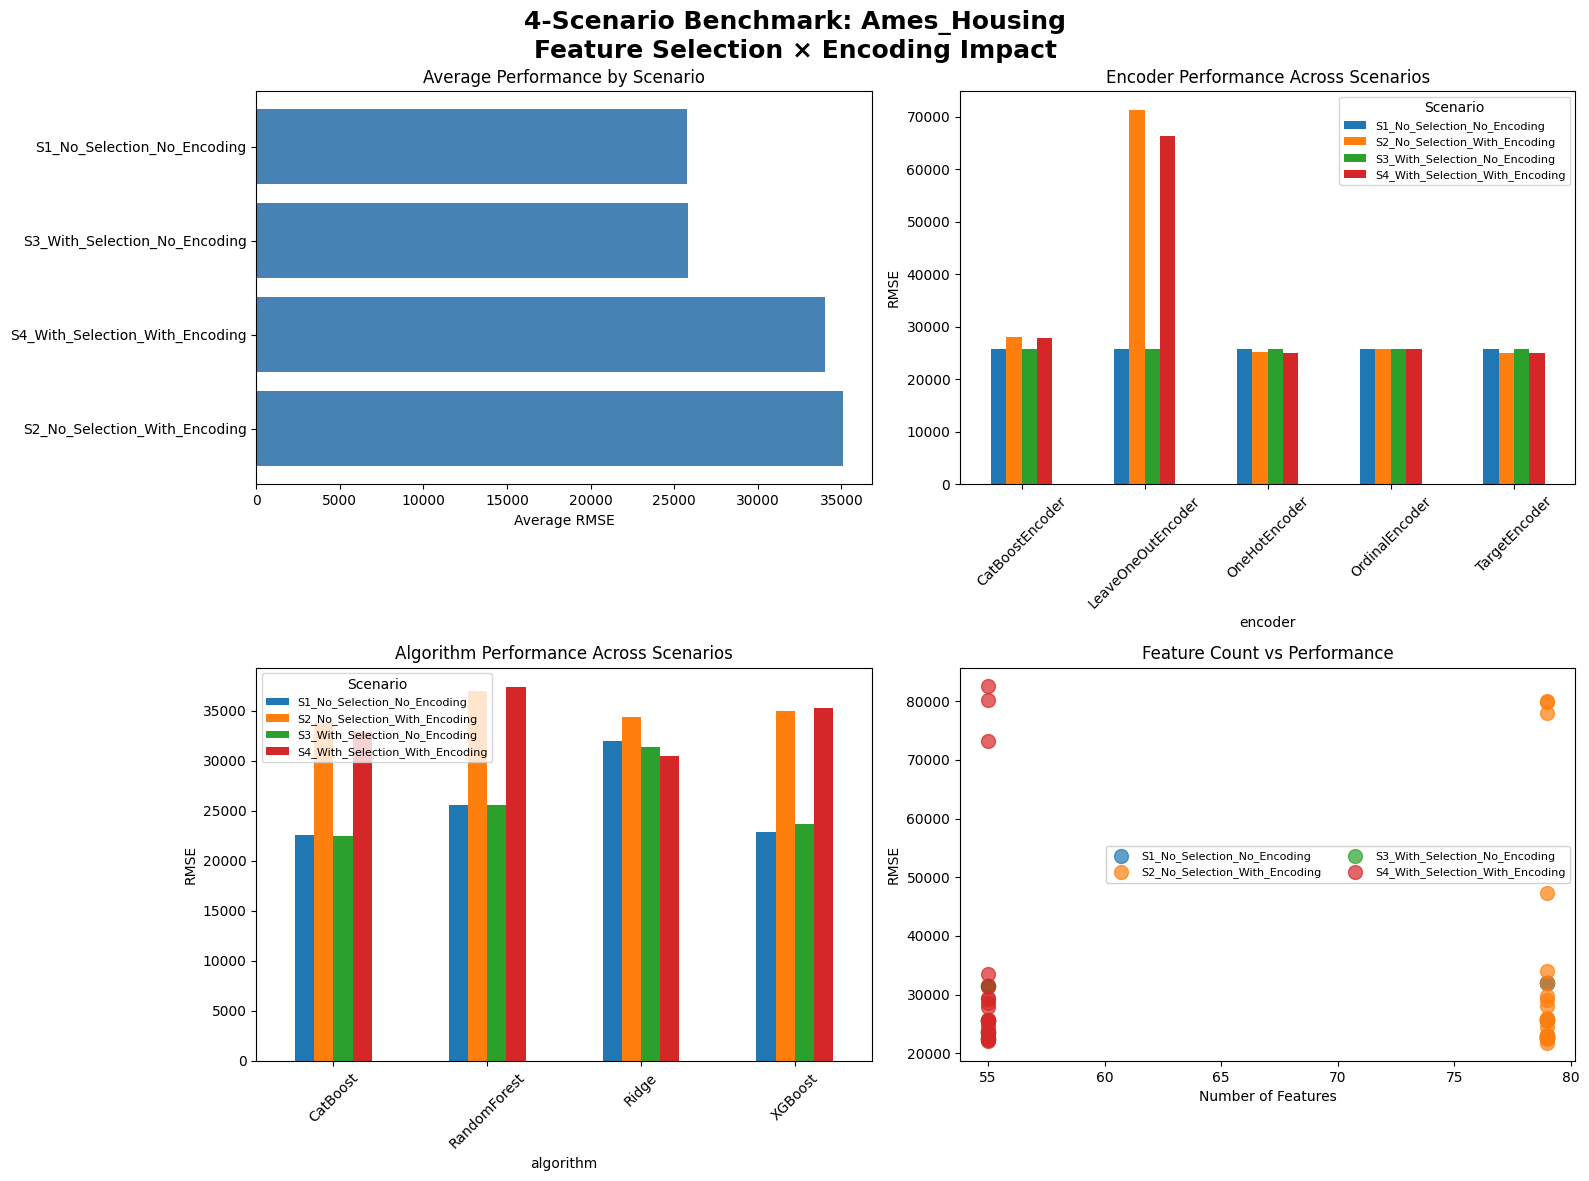

✓ Visualization saved to '../results/Ames_Housing_four_scenario_comparison.png'
✓ Results saved to: ../results/Ames_Housing_benchmark_results.csv

=========================✅ BENCHMARK COMPLETE=========================


▶️                   DATASET: Student_Performance_Math                  
Fetching Student Performance (math) dataset from UCI...
Starting 4-scenario benchmark...

Running Scenario 1: No feature selection and no encoding
 Testing: Ridge + OneHotEncoder
RMSE: 3
 Testing: RandomForest + OneHotEncoder
RMSE: 3
 Testing: XGBoost + OneHotEncoder
RMSE: 3
 Testing: CatBoost + OneHotEncoder
RMSE: 3
 Testing: Ridge + TargetEncoder
RMSE: 3
 Testing: RandomForest + TargetEncoder
RMSE: 3
 Testing: XGBoost + TargetEncoder
RMSE: 3
 Testing: CatBoost + TargetEncoder
RMSE: 3
 Testing: Ridge + OrdinalEncoder
RMSE: 3
 Testing: RandomForest + OrdinalEncoder
RMSE: 3
 Testing: XGBoost + OrdinalEncoder
RMSE: 3
 Testing: CatBoost + OrdinalEncoder
RMSE: 3
 Testing: Ridge + CatBoostEncoder
RMSE: 

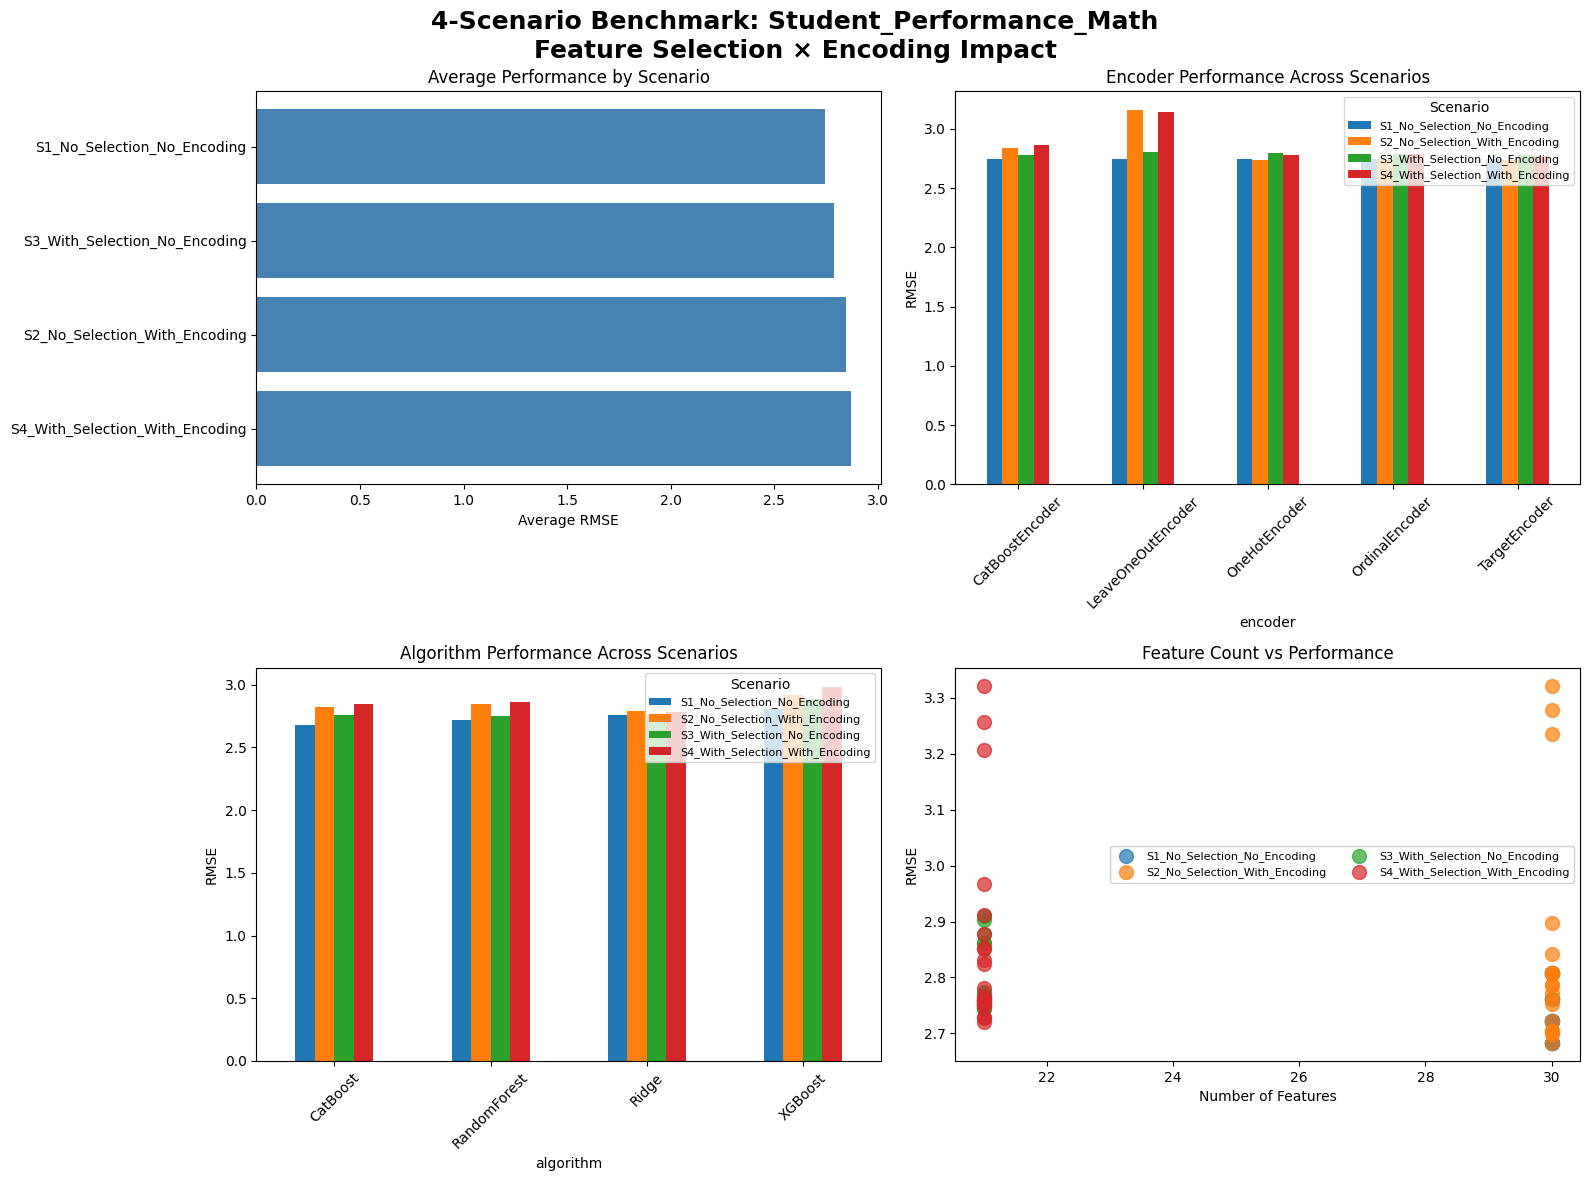

✓ Visualization saved to '../results/Student_Performance_Math_four_scenario_comparison.png'
✓ Results saved to: ../results/Student_Performance_Math_benchmark_results.csv

=========================✅ BENCHMARK COMPLETE=========================


======================🔍 CROSS-DATASET COMPARISON======================

                 Dataset  Best_Encoder Best_Algorithm                 Best_Scenario    Best_RMSE     Avg_RMSE  Num_Features
            Ames_Housing TargetEncoder       CatBoost S2_No_Selection_With_Encoding 21733.074697 30164.484374            79
Student_Performance_Math OneHotEncoder       CatBoost   S1_No_Selection_No_Encoding     2.682600     2.811519            30


🎉 ALL BENCHMARKS COMPLETED!


In [7]:
# ## Run Baseline Test
print("\n" + "🔬 ENCODING BENCHMARK SUITE".center(70, "="))
print(f"Running benchmarks on {len(DATASETS_TO_RUN)} dataset(s)\n")

# Store all results
all_results = {}

for dataset_name, load_function in DATASETS_TO_RUN.items():
    print("\n" + "▶️  " + f"DATASET: {dataset_name}".center(68, " "))
    print("="*70)
    
    # Load data
    X, y, cat_columns, num_columns = load_function()
    
    if X is not None:
        # Initialize and run benchmark
        baseline = EncodingBenchmark(random_state=42)
        
        # Run the test
        print(f"Starting 4-scenario benchmark...\n")
        results = baseline.run_scenarios(X, y, cat_columns, num_columns)
        
        # Analyze results
        print("\n" + "📊 ANALYSIS".center(70, "-"))
        analysis = baseline.analyze_results(results)
        
        # Visualize results
        print("\n" + "📈 VISUALIZATION".center(70, "-"))
        baseline.visualize_results(results, dataset_name=dataset_name)
        
        # Save results with dataset name
        output_file = f'../results/{dataset_name}_benchmark_results.csv'
        results.to_csv(output_file, index=False)
        print(f"✓ Results saved to: {output_file}")
        
        # Store for comparison
        all_results[dataset_name] = results
        
        print("\n" + "✅ BENCHMARK COMPLETE".center(70, "=") + "\n")
    else:
        print(f"⚠️  Skipping {dataset_name} due to loading error\n")


# ============================================================
# Cell 6: CROSS-DATASET COMPARISON
# ============================================================
if len(all_results) > 1:
    print("\n" + "🔍 CROSS-DATASET COMPARISON".center(70, "="))
    
    comparison_data = []
    for dataset_name, results_df in all_results.items():
        best_overall = results_df.loc[results_df['rmse_mean'].idxmin()]
        comparison_data.append({
            'Dataset': dataset_name,
            'Best_Encoder': best_overall['encoder'],
            'Best_Algorithm': best_overall['algorithm'],
            'Best_Scenario': best_overall['scenario'],
            'Best_RMSE': best_overall['rmse_mean'],
            'Avg_RMSE': results_df['rmse_mean'].mean(),
            'Num_Features': best_overall['number_features']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))
    print("\n" + "="*70)

print("\n🎉 ALL BENCHMARKS COMPLETED!")

